In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt
from PIL import Image
import skimage.transform as skTrans

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import tarfile
extract = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')
extract.extractall()

In [4]:
path1 = "/kaggle/working/BraTS2021_01154/BraTS2021_01154_t1ce.nii.gz"
path2 = "/kaggle/working/BraTS2021_01154/BraTS2021_01154_t2.nii.gz"
path3 = "/kaggle/working/BraTS2021_01154/BraTS2021_01154_flair.nii.gz"
path4 = "/kaggle/working/BraTS2021_01154/BraTS2021_01154_seg.nii.gz"
path5 = "/kaggle/working/BraTS2021_01154/BraTS2021_01154_t1.nii.gz"

In [5]:
Input_Images = os.listdir('/kaggle/working')[:20]
xtrain = np.array([])
ytrain = np.array([])
s = 0 
for i in Input_Images:
    # Extracting the path of the Image
    rel = i + "/" + i + '_flair.nii.gz'
    pathinp = os.path.join('/kaggle/working',rel)
    rel = i + "/" + i + '_seg.nii.gz'
    pathseg = os.path.join('/kaggle/working',rel)
    # Loading the image
    Image1 = nl.image.load_img(pathinp)
    Img_seg= nl.image.load_img(pathseg)
    # Resizing the image
    Image1 = skTrans.resize(Image1.get_fdata(),(64,64,64),order=1,preserve_range= True).reshape(1,64,64,64,1)
    Img_seg = skTrans.resize(Img_seg.get_fdata(),(64,64,64),order=1,preserve_range= True).reshape(1,64,64,64,1)
    # Stacking the data
    if(s==0):
        xtrain = Image1
        ytrain = Img_seg
        s = 1
    else:
        xtrain = np.vstack((xtrain,Image1))
        ytrain = np.vstack((ytrain,Img_seg))
    

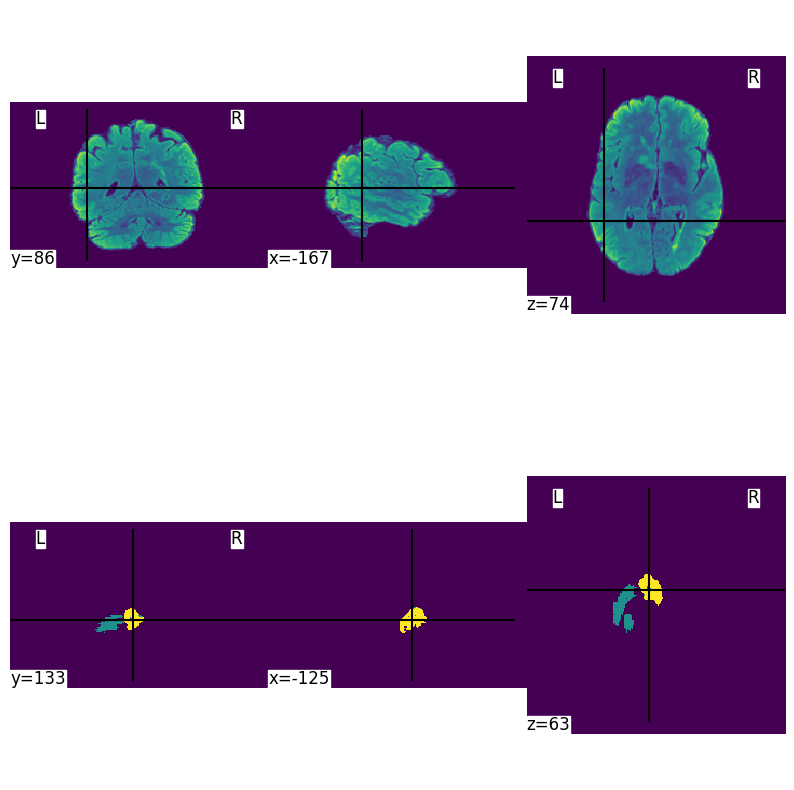

In [6]:
Image1 = nl.image.load_img(path3)
Img_seg= nl.image.load_img(path4)
fig,axes = plt.subplots(nrows=2,figsize=(10,10))
nlplt.plot_img(Image1,axes=axes[0])
nlplt.plot_img(Img_seg,axes=axes[1])
im1_in = skTrans.resize(Image1.get_fdata(),(64,64,64),order=1,preserve_range= True)
im1_out = skTrans.resize(Img_seg.get_fdata(),(64,64,64),order=1,preserve_range= True)

In [26]:
from keras import Model
import keras.backend as trace
from keras.layers import Layer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv3D,Conv3DTranspose,MaxPooling3D,Attention,GroupNormalization,Activation,Input,Concatenate

In [8]:
def Round(x):
    return round(x,3)

In [41]:
class DiceLoss:
    def __init__(self,smooth,f1):
        self.smooth = smooth
        self.Round = f1 ;
    def metric(self,y_true,y_pred):
        inputs = tf.keras.layers.Flatten()(y_true)
        targets = tf.keras.layers.Flatten()(y_pred)
        intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
        dice = (2*intersection ) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
#         dice = tf.keras.layers.Lambda(round)(dice)
        return 1 - dice

In [42]:
#Loss Function
import tensorflow as tf
class Tversky_loss():
    def __init__(self,al,bet):
        self.al = al 
        self.bet = bet
        self.const = tf.constant(np.array([1.]),dtype=tf.float32)
    def loss(self,y_true,y_pred):
        y_t = tf.keras.layers.Flatten()(y_true)
        y_p = tf.keras.layers.Flatten()(y_pred)
        Neu = tf.reduce_sum(tf.multiply(y_t,y_p)) + 1e-7
        Deno = tf.add(tf.add(tf.reduce_sum(tf.multiply(y_t,y_p)),tf.multiply(self.al,tf.reduce_sum(tf.multiply(tf.subtract(self.const,y_t),y_p)))),\
                     tf.multiply(self.bet,tf.reduce_sum(tf.multiply(tf.subtract(self.const,y_p),y_t))))
        return tf.divide(Neu,Deno)

In [43]:
def Model_main(inp_shape,K):
    # Block 1
    X1 = Input(shape=inp_shape)
    X2 = Conv3D(32,K,padding='same')(X1)
    X2 = GroupNormalization(groups=32,axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = Conv3D(32,K,padding='same')(X2)
    X2 = GroupNormalization(groups=32,axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X3 = MaxPooling3D(2)(X2)
    # Block 2
    X3 = Conv3D(64,K,padding='same')(X3)
    X3 = GroupNormalization(groups=64,axis=-1)(X3)
    X3 = Activation('relu')(X3)
    X3 = Conv3D(64,K,padding='same')(X3)
    X3 = GroupNormalization(groups=64,axis=-1)(X3)
    X3 = Activation('relu')(X3)
    X4 = MaxPooling3D(2)(X3)
    # Block 3
    X4 = Conv3D(128,K,padding='same')(X4)
    X4 = GroupNormalization(groups=128,axis=-1)(X4)
    X4 = Activation('relu')(X4)
    X4 = Conv3D(128,K,padding='same')(X4)
    X4 = GroupNormalization(groups=128,axis=-1)(X4)
    X4 = Activation('relu')(X4)
    X5 = MaxPooling3D(2)(X4)
    # Block 4
    X5 = Conv3D(256,K,padding='same')(X5)
    X5 = GroupNormalization(groups=256,axis=-1)(X5)
    X5 = Activation('relu')(X5)
    X5 = Conv3D(256,K,padding='same')(X5)
    X5 = GroupNormalization(groups=256,axis=-1)(X5)
    X5 = Activation('relu')(X5)
    # Block 5
    X6 = Conv3DTranspose(128,2,2,activation='relu')(X5)
    X7 = Attention()([X6,X4])
    X7 = Concatenate()([X6,X7])
    X8 = Conv3D(64,K,padding='same')(X7)
    X8 = GroupNormalization(groups=64,axis=-1)(X8)
    X8 = Activation('relu')(X8)
    X8 = Conv3D(64,K,padding='same')(X7)
    X8 = GroupNormalization(groups=64,axis=-1)(X8)
    X8 = Activation('relu')(X8)
    # Block 6
    X9  = Conv3DTranspose(64,2,2,activation='relu')(X8)
    X10 = Attention()([X9,X3])
    X10 = Concatenate()([X9,X10])
    X11 = Conv3D(32,K,padding='same')(X10)
    X11 = GroupNormalization(groups=32,axis=-1)(X11)
    X11 = Activation('relu')(X11)
    X11 = Conv3D(32,K,padding='same')(X11)
    X11 = GroupNormalization(groups=32,axis=-1)(X11)
    X11 = Activation('relu')(X11)
    # Block 7
    X12 = Conv3DTranspose(32,2,2,activation='relu')(X11)
    X13 = Attention()([X12,X2])
    X13 = Concatenate()([X12,X13])
    model = Model(X1,X13)
    return model

In [44]:
def Branch():
    model2 = Sequential()
    model2.add(Conv3D(16,3,padding='same',input_shape=(64, 64, 64, 64)))
    model2.add(GroupNormalization(groups=16,axis=-1))
    model2.add(Activation('relu'))
    model2.add(Conv3D(16,3,padding='same',input_shape=(64, 64, 64, 64)))
    model2.add(GroupNormalization(groups=16,axis=-1))
    model2.add(Activation('relu'))
    model2.add(Conv3D(1,20,1,padding='same'))
#     model2.compile(optimizer='adam',loss=Loss.loss,metrics=metrics.metric)
    return model2

In [45]:
opt = Adam(learning_rate=0.001)

In [46]:
Main = Model_main((64,64,64,1),3)
Branch_mean = Branch()
model_mean_main  = Sequential([Main,Branch_mean])

In [47]:
Loss_mean = Tversky_loss(al=0.5,bet=0.5)
metric=DiceLoss(1e-6,Round)

In [48]:
model_mean_main.compile(optimizer=opt,loss=Loss_mean.loss,metrics=metric.metric)

In [49]:
model_mean_main.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 64, 64, 64, 64)    4399360   
                                                                 
 sequential_14 (Sequential)  (None, 64, 64, 64, 1)     162657    
                                                                 
Total params: 4,562,017
Trainable params: 4,562,017
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_mean_main.fit(xtrain,ytrain,epochs=10)

Epoch 1/10
1/1 [==============================] - 27s 27s/step - loss: 0.0267 - metric: 0.9733
Epoch 2/10
1/1 [==============================] - 22s 22s/step - loss: 0.1055 - metric: 0.8945
Epoch 3/10
1/1 [==============================] - 21s 21s/step - loss: 0.0733 - metric: 0.9267
Epoch 4/10
1/1 [==============================] - 21s 21s/step - loss: 0.0537 - metric: 0.9463
Epoch 5/10
1/1 [==============================] - 21s 21s/step - loss: 0.0396 - metric: 0.9604
Epoch 6/10
1/1 [==============================] - 21s 21s/step - loss: 0.0294 - metric: 0.9706
Epoch 7/10
1/1 [==============================] - 21s 21s/step - loss: 0.0220 - metric: 0.9780
Epoch 8/10
1/1 [==============================] - 21s 21s/step - loss: 0.0167 - metric: 0.9833
Epoch 9/10
1/1 [==============================] - 21s 21s/step - loss: 0.0124 - metric: 0.9876
Epoch 10/10
1/1 [==============================] - 21s 21s/step - loss: 0.0088 - metric: 0.9912


In [51]:
for layers in Main.layers:
    layers.trainable = 'false'

In [52]:
Branch_lower = Branch()
model_lower_main  = Sequential([Main,Branch_mean])
Loss_lower = Tversky_loss(al=0.2,bet=0.8)
model_lower_main.compile(optimizer=opt,loss=Loss_lower.loss,metrics=metric.metric)
model_lower_main.fit(xtrain,ytrain,epochs=10)

Epoch 1/10
1/1 [==============================] - 26s 26s/step - loss: 0.0140 - metric: 0.9944
Epoch 2/10
1/1 [==============================] - 22s 22s/step - loss: 0.0057 - metric: 0.9977
Epoch 3/10
1/1 [==============================] - 21s 21s/step - loss: -0.0024 - metric: 1.0010
Epoch 4/10
1/1 [==============================] - 21s 21s/step - loss: -0.0096 - metric: 1.0038
Epoch 5/10
1/1 [==============================] - 21s 21s/step - loss: -0.0164 - metric: 1.0065
Epoch 6/10
1/1 [==============================] - 21s 21s/step - loss: -0.0236 - metric: 1.0095
Epoch 7/10
1/1 [==============================] - 21s 21s/step - loss: -0.0316 - metric: 1.0126
Epoch 8/10
1/1 [==============================] - 21s 21s/step - loss: -0.0419 - metric: 1.0167
Epoch 9/10
1/1 [==============================] - 21s 21s/step - loss: -0.0553 - metric: 1.0221
Epoch 10/10
1/1 [==============================] - 21s 21s/step - loss: -0.0715 - metric: 1.0286


In [53]:
Branch_upper = Branch()
model_upper_main  = Sequential([Main,Branch_lower])
Loss_upper = Tversky_loss(al=0.8,bet=0.2)
model_upper_main.compile(optimizer=opt,loss=Loss_upper.loss,metrics=metric.metric)
model_upper_main.fit(xtrain,ytrain,epochs=10)

Epoch 1/10
1/1 [==============================] - 27s 27s/step - loss: 0.0644 - metric: 0.9003
Epoch 2/10
1/1 [==============================] - 22s 22s/step - loss: -0.0063 - metric: 1.0100
Epoch 3/10
1/1 [==============================] - 21s 21s/step - loss: -0.0192 - metric: 1.0307
Epoch 4/10
1/1 [==============================] - 21s 21s/step - loss: -0.0385 - metric: 1.0616
Epoch 5/10
1/1 [==============================] - 21s 21s/step - loss: -0.0602 - metric: 1.0963
Epoch 6/10
1/1 [==============================] - 21s 21s/step - loss: -0.0883 - metric: 1.1411
Epoch 7/10
1/1 [==============================] - 21s 21s/step - loss: -0.1354 - metric: 1.2164
Epoch 8/10
1/1 [==============================] - 21s 21s/step - loss: -0.2470 - metric: 1.3949
Epoch 9/10
1/1 [==============================] - 21s 21s/step - loss: -1.5133 - metric: 3.4100
Epoch 10/10
1/1 [==============================] - 21s 21s/step - loss: 0.2470 - metric: 0.6045
